In [1]:
import numpy as np
from skimage.io import imread
from skimage.util import random_noise
from skimage.transform import rescale
import matplotlib.pyplot as plt
import cv2
from scipy.signal import correlate2d
# Funciones que transforman un arreglo de una imagen en el espacio RGB a otro espacio de color
from skimage.color import rgb2hsv, rgb2lab
# Funciones para pasar de hsv y lab de vuelta a rgb. Necesarias para visualizar el color asociado a cada bin
from skimage.color import hsv2rgb, lab2rgb
# Funcion para representar un color en el espacio rgb en formato hexadecimal
from matplotlib.colors import rgb2hex

# Filtros No Lineales y Color

En este tutorial estudiaremos algunos filtros no lineales y su utilidad para reducir el ruido impulsional. Se presentará una implementación del filtro mediano adaptativo y se expondrá brevemente la lógica detrás de su funcionamiento. Finalmente, estudiaremos cómo representar una imagen a partir de su histograma de intensidades conjunto o concatenado en distintos espacios de color.

## Filtros No Lineales

Los filtros no lineales son aquellos cuya salida no puede expresarse como una combinación lineal de pesos fijos. En otras palabras, son aquellos que no pueden implementarse mediante una cross-correlación. En la mayoria de los casos, las transformaciones de la imagen obtenidas al implementar estos filtros no son invertibles, es decir que a partir de la imagen final no se puede reconstruir la imagen original.

Los filtros de estadística de orden son un tipo particular de filtro no lineal. La salida de estos filtros depende del ordenamiento de intensidades de los píxeles en una ventana, y no de su posición espacial, como en los filtros lineales estudiados en el tutorial pasado. Los filtros mínimo, máximo y mediano son algunos ejemplos de filtros de estadística de orden.

A continuación, se presenta una función que permite implementar estos 3 filtros según un *tipo de filtro* recibido como parámetro:

In [2]:
# Parámetros:
# image: Arreglo de numpy de 2 dimensiones que representa la imagen en blanco y negro
# window_shape: Tupla que representa las dimensiones de la ventana de filtrado
# type: String que indica el tipo de filtro a implementar. Puede tomar los valores de 'min', 'max' o 'median'

def nonlinear_filter(image, window_shape, type):
    
    # Se crea un arreglo en el que se almacena la imagen de salida
    filtered_image = np.zeros(image.shape)
    
    # Definición de variables auxiliares
    m, n = window_shape
    a, b = (m - 1)//2, (n - 1)//2
    
    # Para cada pixel en el que se pueda centrar una ventana de las dimensiones dadas:
    for i in range(a, image.shape[0] - a):
        for j in range(b, image.shape[1] - b):
            # Se seleccionan las intensidades que pertenecen a la ventana
            window = image[i - a :i + a+1 , j - b: j + b +1]
            # Se ordenan las intensidades de menor a mayor en un vector de longitud (nxm)
            ordered_vector = np.sort(window.flatten())
            if type == 'max':
                # Se asigna al pixel central el último elemento del vector ordenado
                filtered_image[i, j] = ordered_vector[-1]
            elif type == 'min':
                # Seasigna al pixel central el primer elemento del vector ordenado
                filtered_image[i, j] = ordered_vector[0]
            elif type == 'median':
                # Se asigna al pixel central el elemento del medio del vector ordenado
                filtered_image[i, j] = ordered_vector[len(ordered_vector) // 2]
            else:
                # Se arroja un error en el caso de que se introduzca por parámetro un filtro no soportado
                raise Exception("Filter type not supported")
    # Se retorna la imagen de salida

    return filtered_image


Para evaluar la capacidad de estos filtros para remover distintos tipos de ruido impulsional, agregaremos ruido de "sal", "pimienta" y "sal y pimienta" a una imagen limpia, y aplicaremos los 3 tipos de filtros implementados a las imagenes resultantes:

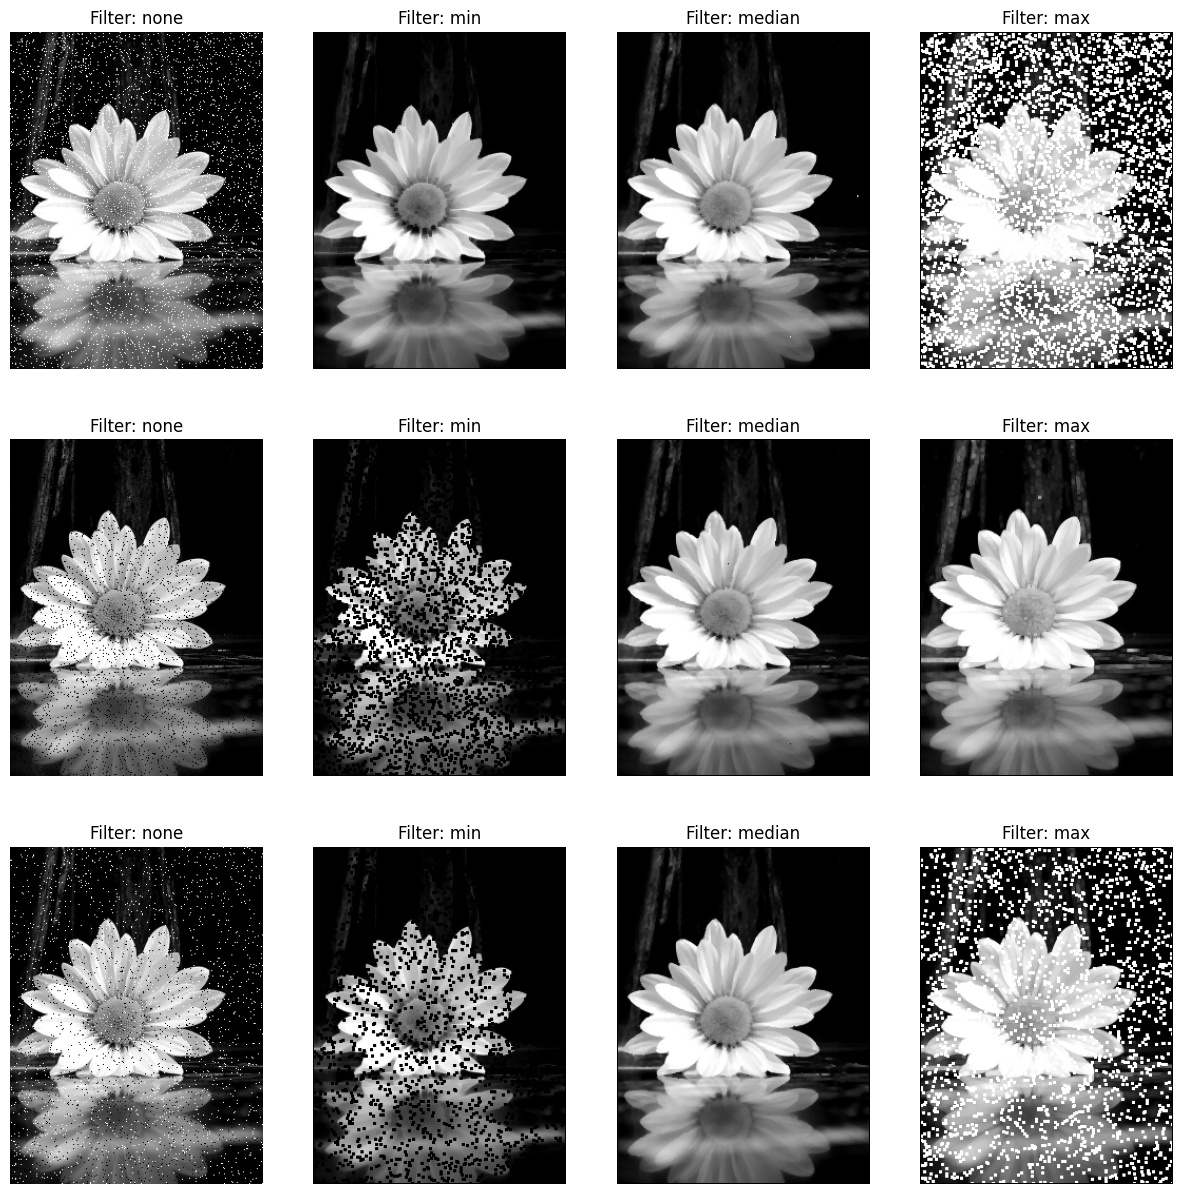

In [3]:
# Se lee la imagen de ejemplo. Se reducen las dimensiones de la imagen para reducir el tiempo que toma filtrar cada imagen
original_img = rescale(imread('flower.jpg', as_gray = True), 0.5)

# Se obtienen imagenes con distintos tipos de ruido impulsional.
salt_img = random_noise(original_img, mode='salt', amount=0.05, rng=3)
pepper_img = random_noise(original_img, mode='pepper', amount=0.05, rng=3)
sp_img = random_noise(original_img, mode='s&p', amount=0.05, rng=3)

# Se crea un arreglo de imagenes y filtros para sintetizar el código de visualización de resultados

images = [[salt_img]*4,
          [pepper_img]*4,
          [sp_img]*4]

types = ['none', 'min', 'median', 'max']

# Visualización

plt.figure(figsize=(15,15))
for i in range(3):
    for j in range(4):
        plt.subplot(3,4, i*4 + j + 1)
        if types[j] == 'none':
            plt.imshow(images[i][j], cmap = 'gray')
        else:
            # Se aplica el filtro no lineal sobre las imagenes con ruido y se grafican
            plt.imshow(nonlinear_filter(images[i][j], (3,3), types[j]), cmap = 'gray')
        plt.title('Filter: ' + types[j])
        plt.axis('Off')
            

Analicemos los resultados obtenidos. Para el ruido impulsional de alta intensidad (sal) el filtro mínimo obtuvo buenos resultados. Esto se debe a que al elegir la mínima intensidad de una ventana se excluyen las intensidades altas asociadas a este tipo de ruido (a menos de que toda la ventana sea ruido impulsional). Sin embargo, note que las regiones oscuras de la imagen original fueron ensanchadas y las regiones claras fueron dilatadas. Esto se debe a que cada nuevo píxel tendrá el valor de intensidad más bajo de su vecindad original. El filtro mediano tuvo un buen desempeño, pero además logró preservar la distribución de intensidades de la imagen original en mayor medida que el filtro mínimo. Esto se debe a que al asignar la intensidad mediana en lugar de la mínima se evita el ensanchamiento y la dilatación mencionadas anteriormente. El filtro máximo tuvo un mal desempeño para este tipo de ruido, pues cada píxel que tuviese ruido impulsional en su vecindad tomaría su valor. Un análisis semejante se puede hacer para el ruido impulsional de baja intensidad (pimienta), considerando que los resultados entre el filtro mínimo y máximo se intercambian. En el caso de ruido sal y pimienta, el fenómeno de ensanchamiento de los impulsos se presenta con el filtro mínimo y máximo, y por lo tanto solo el filtro mediano obtiene buenos resultados.

Note que, si bien el filtro mediano logra filtrar en gran medida el ruido impulsional de los 3 tipos, la imagen resultante se torna borrosa con respecto a la imagen original. Esto sucede porque al elegir la mediana en lugar de la intensidad original de los píxeles que no son ruido se reducen las variaciones de alta frecuencia de la imagen. El filtro mediano adaptativo, implementado a continuación, incorpora un algoritmo que reduce este problema. 


Ahora, vamos a modificar la función anterior para implementar el filtro de k-vecino más cercano. El parametro type de este filtro será "k_nn".

In [4]:
def nonlinear_filter(image, window_shape, type,k=None):
    # Se crea un arreglo en el que se almacena la imagen de salida
    filtered_image = np.zeros(image.shape)
    
    # Definición de variables auxiliares
    m, n = window_shape
    a, b = (m - 1)//2, (n - 1)//2
    
    # Para cada pixel en el que se pueda centrar una ventana de las dimensiones dadas:
    for i in range(a, image.shape[0] - a):
        for j in range(b, image.shape[1] - b):
            # Se seleccionan las intensidades que pertenecen a la ventana
            window = image[i - a :i + a+1, j - b: j + b+1 ]
            # Se ordenan las intensidades de menor a mayor en un vector de longitud (nxm)
            ordered_vector = np.sort(window.flatten())
            if type == 'max':
                # Se asigna al pixel central el último elemento del vector ordenado
                filtered_image[i, j] = ordered_vector[-1]
            elif type == 'min':
                # Seasigna al pixel central el primer elemento del vector ordenado
                filtered_image[i, j] = ordered_vector[0]
            elif type == 'median':
                # Se asigna al pixel central el elemento del medio del vector ordenado
                filtered_image[i, j] = ordered_vector[len(ordered_vector) // 2]
            elif type == 'k_nn':
                # Se asigna al pixel central el elemento del medio del vector ordenado
                distance={}
                for i_o in window.flatten():
                    distance[str(abs(i_o-image[i,j]))]=i_o
                distance_ordered=sorted(distance.items())
                ordered_vector=[]
                for i_o in distance_ordered:
                    if len(ordered_vector)<k+1:
                        ordered_vector.append(float(i_o[1]))
                filtered_image[i, j] = np.mean(ordered_vector)
            else:
                # Se arroja un error en el caso de que se introduzca por parámetro un filtro no soportado
                raise Exception("Filter type not supported")
    # Se retorna la imagen de salida
    return filtered_image

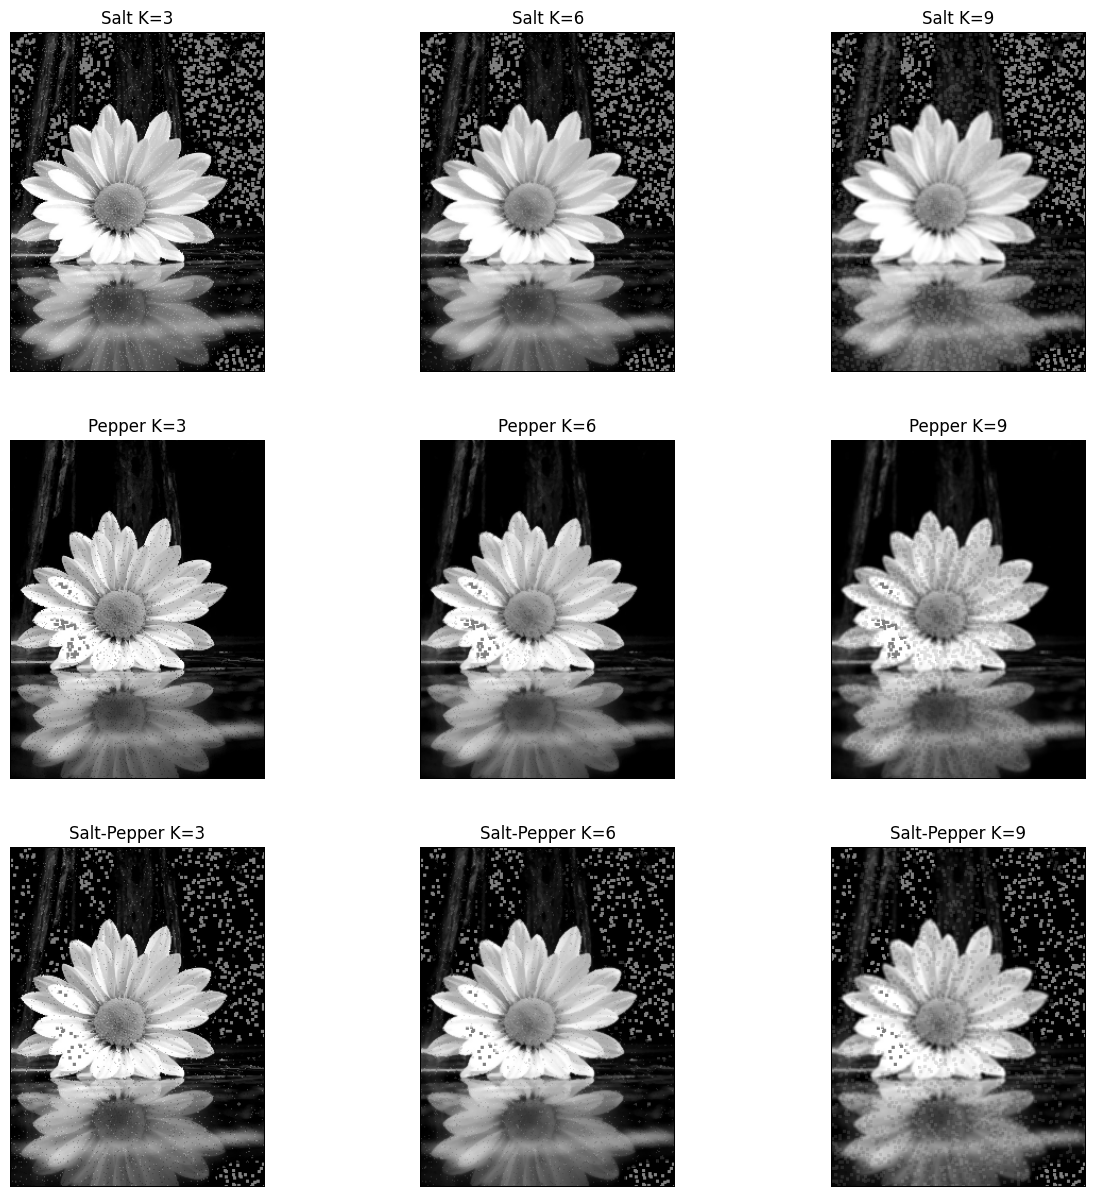

In [5]:
images = [[salt_img]*3,
          [pepper_img]*3,
          [sp_img]*3]

k_nn=[[3,6,9],[3,6,9],[3,6,9]]
noise=[['Salt']*3,['Pepper']*3,['Salt-Pepper']*3]

plt.figure(figsize=(15,15))
for i in range(3):
    for j in range(3):
        plt.subplot(3,3, i*3 + j + 1)
        plt.imshow(nonlinear_filter(images[i][j], (3,3), 'k_nn',k_nn[i][j]), cmap = 'gray')
        plt.title(noise[i][j]+' K='+str(k_nn[i][j]))
        plt.axis('Off')

In [6]:
im1=nonlinear_filter(salt_img, (3,3), 'k_nn',3)
im2=nonlinear_filter(salt_img, (3,3), 'k_nn',9)
media_filtered=correlate2d(salt_img,np.ones((3,3))/9,mode='same')

assert np.isclose(round(np.mean((media_filtered-im2)**2),4),0.0107,0.001), f'Hacer un promedio de 9 vecinos en una ventana 3x3 es como hacer un filtro medio, su MSE deberia ser 0.0107 no y es {round(np.mean((media_filtered-im2)**2),4)}'
assert np.isclose(np.mean((salt_img-im1)**2),0.0296,0.01), 'Su implementación es erronea'

### Ejercicio 1: Filtro Mediano Mejorado

Como una primera aproximación de los filtros adaptativos tenemos el filtro mediano mejorado. Donde su objetivo es promediar píxeles similares al valor mediano.

Recuerden la formula que les ayudará a construir la función.

![Filtro mediano mejorado](Mediano_mejorado.png)

In [7]:
def enhanced_medium_filter(image, window_shape, t):
    imagen = np.zeros(image.shape) # Variable para guardar la imagen resultante
    m, n = window_shape
    a, b = (m - 1)//2, (n - 1)//2
    
    for i in range(a, image.shape[0] - a):
        for j in range(b, image.shape[1] - b):
            window = image[i - a :i + a+1, j - b: j + b+1 ]
            ordered_vector = np.sort(window.flatten())
            if ordered_vector[len(ordered_vector) // 2] >=t:
                imagen[i, j] = ordered_vector[len(ordered_vector) // 2]
            else:
                imagen[i, j] = image[i,j]*0
    return imagen

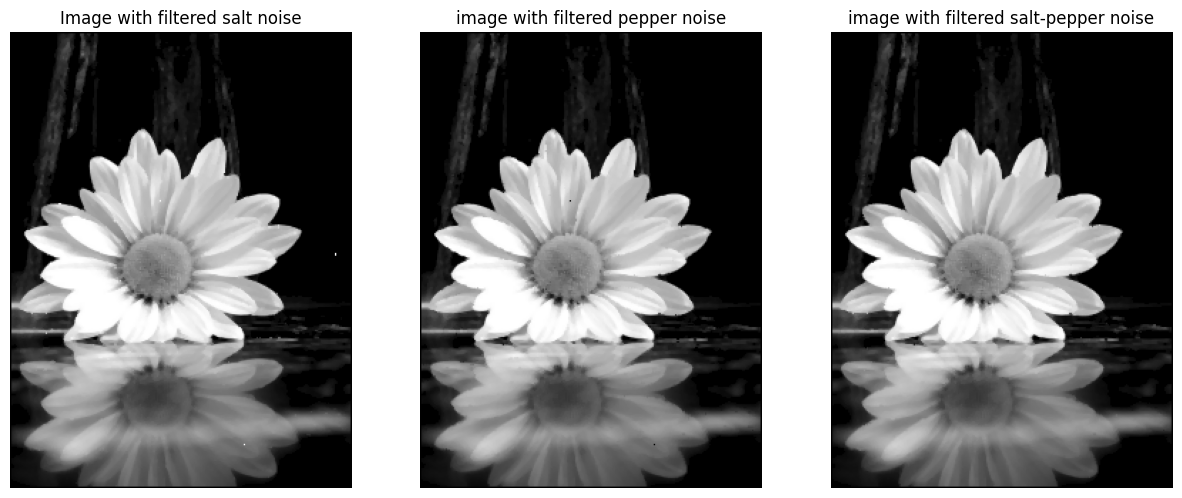

In [8]:
enhanced_medium_filter_ = []
title = ["Image with filtered salt noise", "image with filtered pepper noise", "image with filtered salt-pepper noise"]
enhanced_medium_filter_.append(enhanced_medium_filter(salt_img, (3, 3), 10/255))
enhanced_medium_filter_.append(enhanced_medium_filter(pepper_img, (3, 3), 10/255))
enhanced_medium_filter_.append(enhanced_medium_filter(sp_img, (3, 3), 10/255))

assert np.isclose(np.sum(enhanced_medium_filter_[0]),25151.8,0.01), 'Su implementación es erronea'
assert np.isclose(np.sum(enhanced_medium_filter_[1]),24843,0.01), 'Su implementación es erronea'
assert np.isclose(np.sum(enhanced_medium_filter_[2]),24991.19,0.01), 'Su implementación es erronea'

plt.figure(figsize=(15,15))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(enhanced_medium_filter_[i], cmap = 'gray')
    plt.title(title[i])
    plt.axis('Off')

Podemos observar que los resultados son satisfactorios y comparables con un filtro mediano.

## Filtro Mediano Adaptativo

Con el fin de eliminar el ruido impulsional y a su vez preservar las altas frecuencias de la imagen, el filtro mediano adaptativo implementa el algoritmo sintetizado en el siguiente diagrama:

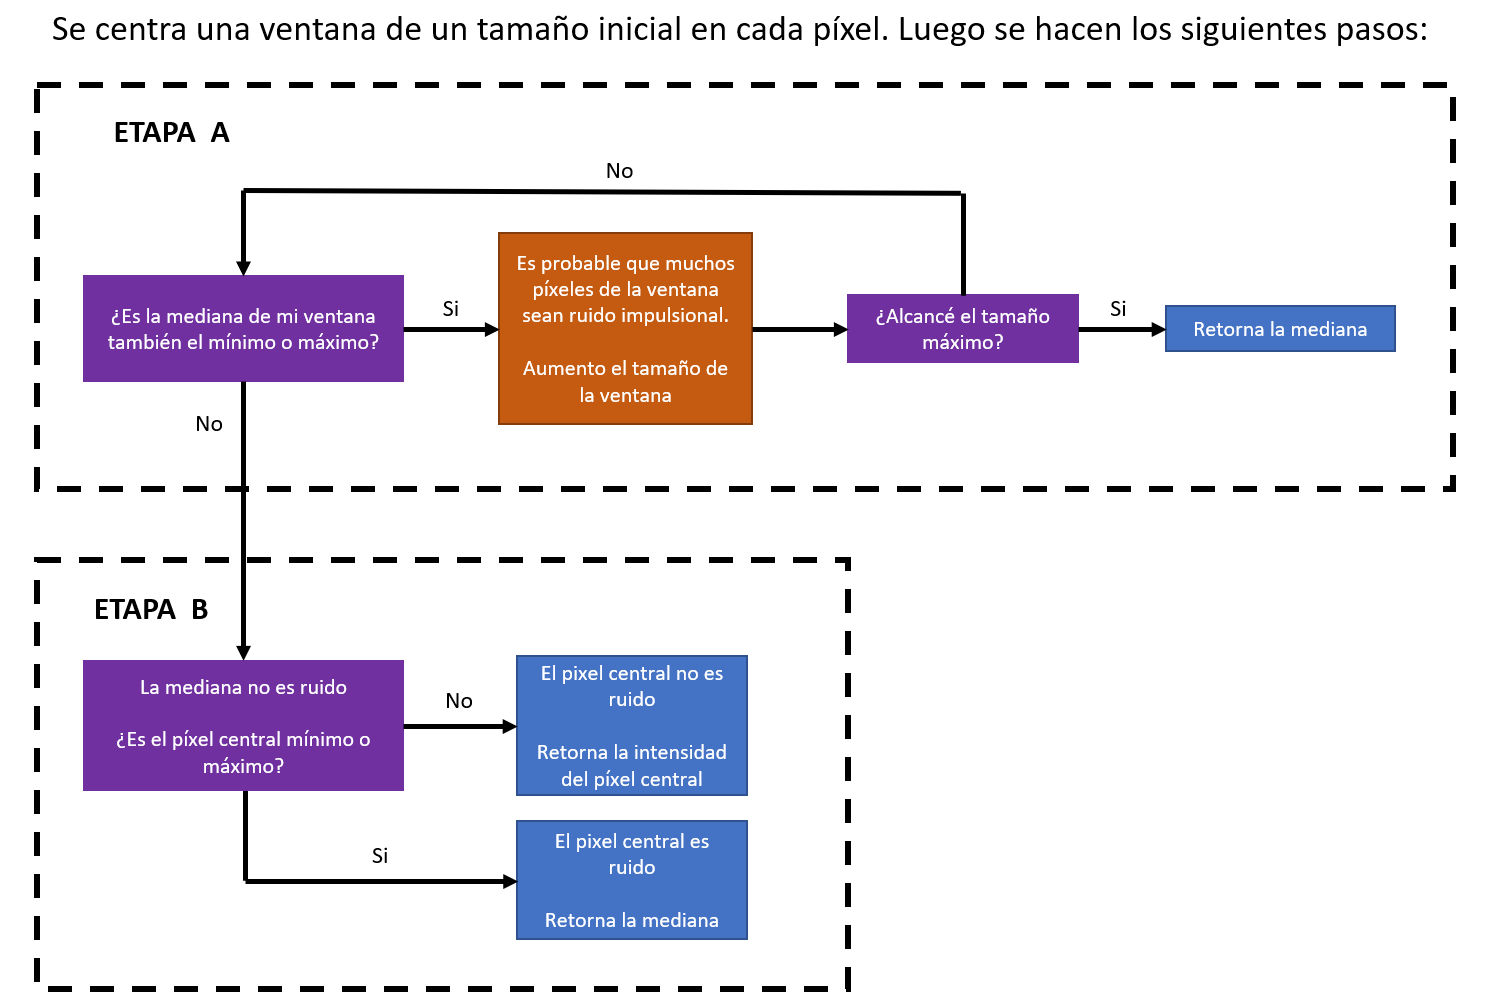

A continuación, se presenta una implementación de este algoritmo:

In [9]:
# Etapa A
def stage_a(Z_min, Z_med, Z_max, Z_xy, S_xy, S_max):
    # Se identifica si la mediana es mínimo o máximo también
    if Z_min < Z_med < Z_max:
        return stage_b(Z_min, Z_med, Z_max, Z_xy)
    else:
        # Se aumenta el tamaño de la ventana
        S_xy += 2
        # Se identifica si se alcanzó el tamaño máximo de ventana
        if(S_xy <= S_max):
            return stage_a(Z_min, Z_med, Z_max, Z_xy, S_xy, S_max)
        else:
            return Z_med

def stage_b(Z_min, Z_med, Z_max, Z_xy):
    # Se identifica si la intensidad del píxel central es mínima o máxima
    if Z_min < Z_xy < Z_max:
        return Z_xy
    else:
        return Z_med
    
def adaptative_median_filter(image, S_0, S_max):
    # Variable auxiliar
    a = (S_max - 1)//2
    # Se crea un arreglo donde se almacenará la imagen de salida
    image_aux=np.zeros((image.shape[0]+2*a,image.shape[1]+2*a))
    image_aux[a:image.shape[0]+a,a:image.shape[1]+a]=image
    output_image = image_aux.copy()
    # Para cada pixel en el que se pueda centrar una ventana de tamaño máximo:
    for i in range(a, image_aux.shape[0] - a):
        for j in range(a, image_aux.shape[1] - a):
            S_xy = S_0
            # Se extraen las intensidades de la ventana
            window = image_aux[i - a :i + a + 1, j - a: j + a + 1]
            # Se ordenan dicahs intensidades en un vector
            ordered_vector = np.sort(window.flatten())
            # Se elige el mínimo, el máximo y la mediana de dicho vector
            Z_min = ordered_vector[0]
            Z_max = ordered_vector[-1]
            Z_med = ordered_vector[len(ordered_vector) // 2]
            # Se extrae la intensidad del píxel central
            Z_xy = image_aux[i, j]
            # Se ejecuta la etapa A descrita previemente
            output_image[i, j] = stage_a(Z_min, Z_med, Z_max, Z_xy, S_xy, S_max)
    # Se retorna la imagen de salida
    return output_image[a:image.shape[0]+a,a:image.shape[1]+a]

A continuación, visualizaremos los resultados de aplicar este filtro sobre las imagenes ruidosas generadas anteriormente:

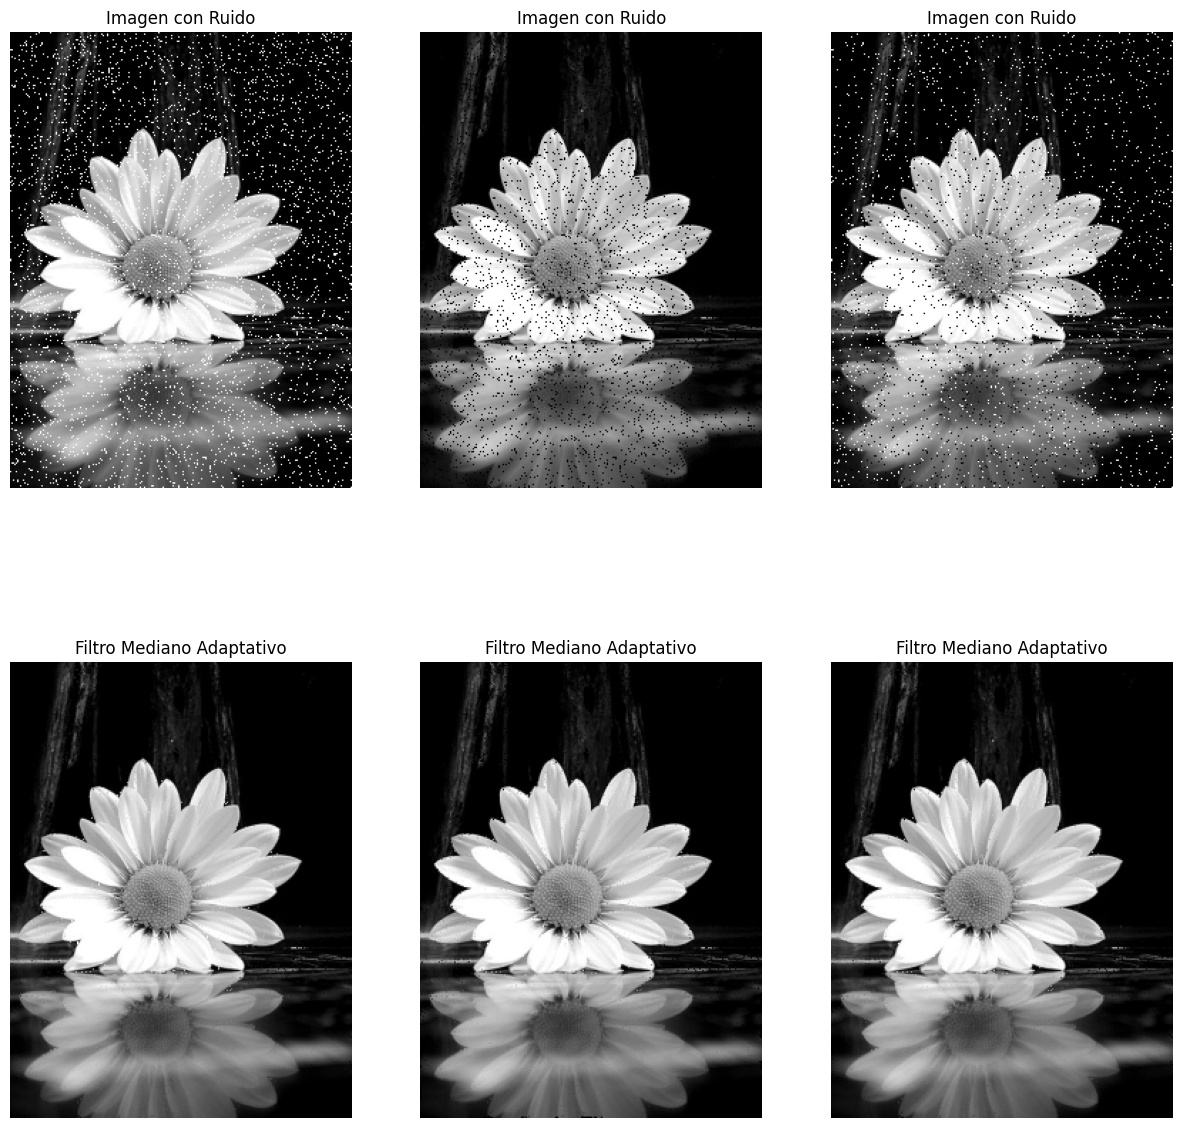

In [10]:
# Visualización de resultados

plt.figure(figsize=(15,15))
images = [salt_img, pepper_img, sp_img]
for i in range(3):
    plt.subplot(2, 3, i + 1)
    plt.title("Imagen con Ruido")
    plt.imshow(images[i], cmap='gray')
    plt.axis('Off')
    
    plt.subplot(2, 3, i + 4)
    plt.title("Filtro Mediano Adaptativo")
    plt.imshow(adaptative_median_filter(images[i], 3, 11), cmap='gray')
    plt.axis('Off')

## Filtro bilateral

Uno de los filtros más importantes es el filtro bilateral, debido a su capacidad para discernir los bordes de otras regiones de la imagen y así preservar mejor los bordes en una imagen. Recordemos que el filtro bilateral es en realidad la multiplicación de dos kernels, cómo se muestra en la siguiente image:

![filtro bilateral](Filtro_bilateral.png)

En conjunto, los kernels calculan persos para un píxel (k, l) respecto a un píxel central (i, j). Los pesos indicarán qué tanto influye el valor de un píxel (k, l) en el valor final de un píxel (i, j)

Ahora, se utiliza el filtro bilateral de la librería cv2. En el siguiente [enlace](https://docs.opencv.org/4.x/d4/d86/group__imgproc__filter.html#ga9d7064d478c95d60003cf839430737ed) pueden encontrar la respectiva documentacion.

(np.float64(-0.5), np.float64(239.5), np.float64(319.5), np.float64(-0.5))

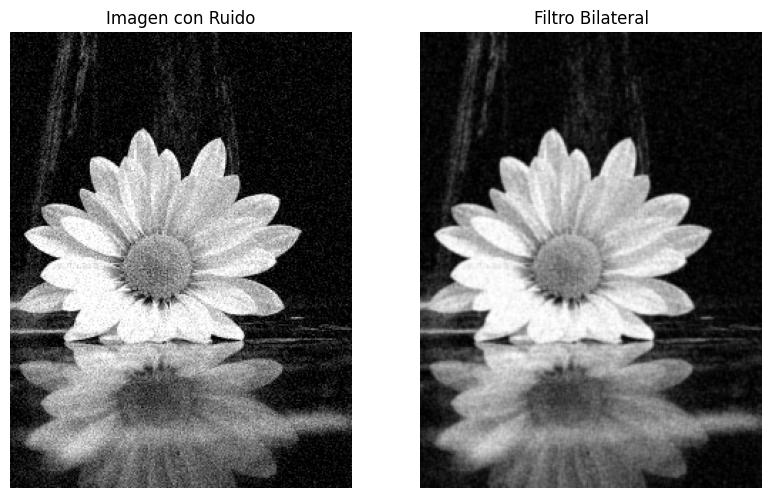

In [11]:
gaussian_img = random_noise(original_img, mode='gaussian', mean = 0, var = 0.005, rng=3)

result = cv2.bilateralFilter(gaussian_img.astype("float32"), 2, 10, 1)

plt.figure(figsize=(15,15))

plt.subplot(2, 3, 1)
plt.title("Imagen con Ruido")
plt.imshow(gaussian_img, cmap='gray')
plt.axis('Off')

plt.subplot(2, 3, 2)
plt.title("Filtro Bilateral")
plt.imshow(result, cmap='gray')
plt.axis('Off')

En el resultado anterior podemos observar el resultado de realizar un filtrado bilateral en una imagen con ruido gaussiano. Aunque, la imagen no es exactamente cómo la original hizo un gran trabajo al eliminar parte del ruido sin que se perdiera mucha información de los bordes de la imagen.

## Color

Tal como se ha visto en clase, una imagen a color se representa mediante un arreglo de 3 dimensiones. Dos de sus dimensiones corresponden al alto y ancho de la imagen, mientras que la tercera dimension corresponde al *canal*. El color asociado a un píxel está determinado por una función de las intensidades de los canales correspondientes a su posición. Cada uno de estos canales se puede interpretar como una coordenada en un espacio de color. Uno de los espacios de color más comunes es el RGB, el cual consta de 3 canales, los cuales indican la proporción de rojo, verde y azul del píxel respectivamente. La función `imread` de la librería `skimage.io` está predeterminada para leer las imágenes en formato RGB. Sin embargo, existen más espacios de color, como HSV y LAB. Los canales del espacio de color HSV representan propiedades físicas interpretables (matiz, saturación y valor respectivamente), mientras que los canales del espacio LAB están establecidos para que las distancias entre colores sean coherentes con las diferencias en la percepción humana del color. A continuación, leeremos una imágen a color, la visualizaremos, e identificaremos las dimensiones del arreglo que la representa: 

El arreglo que representa a la imagen en el espacio del color RGB tiene las siguientes dimensiones: 


(725, 966, 3)

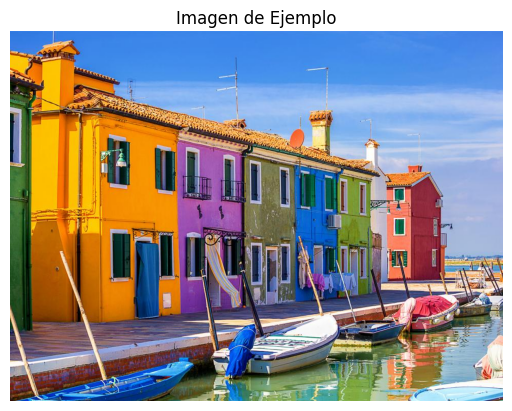

In [12]:
rgb_image = imread('murano.jpeg')

plt.figure()
plt.imshow(rgb_image)
plt.title("Imagen de Ejemplo")
plt.axis('Off')
print("El arreglo que representa a la imagen en el espacio del color RGB tiene las siguientes dimensiones: ")
rgb_image.shape

Así como podemos representar la distribución de intensidades de una imagen a blanco y negro mediante un histograma, también lo podemos hacer en las imágenes a color. Sin embargo, la existencia de múltiples canales implica tomar una decisión con respecto a la definición de los *bins* en los cuales se van a distribuir las frecuencias. 

### Ejericio 2: Histograma de color concatenado 
Una primera opción consiste en calcular el histograma de cada canal, definiendo a los *bins* como un rango en la intensidad de un solo canal, y concatenar dichos histogramas. Implemente una función que permite obtener el **histograma concatenado** de una imagen para distintos espacios de color cuyas transformaciones asociadas son ingresadas como parámetro:

In [13]:
# Parámetros:
# image: Imagen de la cual se quiere obtener su histograma concatenado
# bins_per_channel: Cantidad de bins que tendrá el histograma de cada canal. Es una lista de bins, si la imagen tiene m canales, la lista será de m datos.
# color_space_transform: Una función que mapee una imagen del espacio de color RGB a otro espacio de color

def concatenated_histogram(image, bins_per_channel, color_space_transform = None):
    if color_space_transform is not None:
        image = color_space_transform(image)

    imagen = (image - image.min()) / (image.max() - image.min())

    histograma = []
    for x in range(3):
        h, innecesario = np.histogram(imagen[:, :, x].flatten(),bins=bins_per_channel[x],range=(0, 1))
        histograma.append(h)
    concat_hist = np.concatenate(histograma)
    
    return concat_hist

A continuación, visualizaremos los histogramas concatenados para la imagen presentada anteriormente en los espacios de color RGB, HSV y LAB. Las gráficas obtenidas incluyen líneas punteadas divisorias que delimitan el histograma de cada canal:

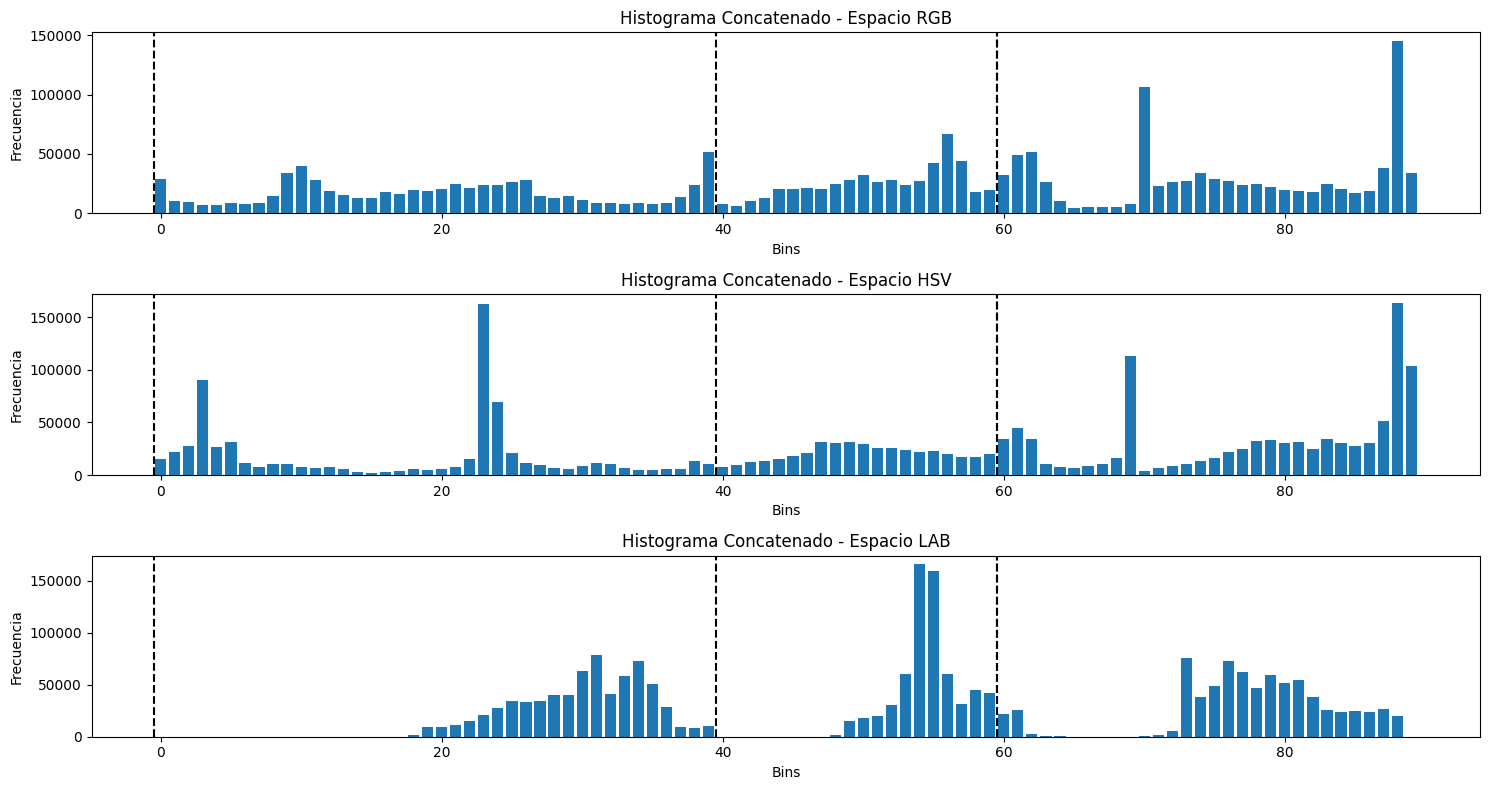

In [ ]:
bins_per_channel = [40,30,20]
transforms = [None, rgb2hsv, rgb2lab]
titles = ["RGB", "HSV", "LAB"]

concat_hist=concatenated_histogram(rgb_image, bins_per_channel, transforms[0])

assert len(concat_hist.shape)==1, 'El histograma concatenado debería tener una sola dimensión'
assert len(concat_hist==bins_per_channel[0]+bins_per_channel[1]+bins_per_channel[2]), 'Los bins del histograma final debería ser la suma de los bins de cada canal'
assert np.isclose(np.sum(np.histogram(rgb_image[:,:,0].flatten(), bins=bins_per_channel[0])[0]-concat_hist[:bins_per_channel[0]]),0), 'El histograma del canal R está mal calculado'

# Visualización
plt.figure(figsize=(15,8))
for i in range(3):
    plt.subplot(3, 1, 1 + i)
    plt.bar(range(bins_per_channel[0]+bins_per_channel[1]+bins_per_channel[2]) ,concatenated_histogram(rgb_image, bins_per_channel, transforms[i]))
    plt.axvline(-0.5, color='k', ls='--', label="R")
    plt.axvline(bins_per_channel[0] - 0.5, color='k', ls='--')
    plt.axvline(bins_per_channel[1] * 2 - 0.5, color='k', ls='--')
    plt.axvline(bins_per_channel[2] * 3 - 0.5, color='k', ls='--')
    plt.title("Histograma Concatenado - Espacio " + titles[i])
    plt.ylabel("Frecuencia")
    plt.xlabel("Bins")

plt.tight_layout()

### Histograma de color conjunto
Una segunda posibilidad consiste en definir los *bins* como una intersección de rangos en cada canal. En otras palabras, un píxel debe estar en un rango definido de intensidades para cada canal para ser incluido en la frecuencia de dicho *bin*. A esto se le conoce como **histograma conjunto**. Para visualizar un histograma conjunto en un espacio de color de 3 dimensiones se requiere hacer una gráfica en 3 dimensiones. Además, la cantidad de bins corresponde al producto entre la cantidad de rangos considerados para los 3 canales, por lo que las dimensiones de este histograma aumentan mucho más que las del histograma concatenado al variar este parámetro. A continuación, se presenta una implementación de una función que permite obtener un histograma conjunto:

In [15]:
def joint_histogram(image, bins_per_channel, color_space_transform = None):
    if color_space_transform is not None:
        image = color_space_transform(image)
    # Las intensidades de la imagen de dimensiones (m, n, 3) se reordenan en una matriz de dimensiones (3, m x n)
    # para satisfacer los requerimientos de la función histogramdd de numpy
    intensities = np.stack([image[:, :, 0].flatten(), 
                           image[:, :, 1].flatten(),
                           image[:, :, 2].flatten()], axis=1)
    # Se obtiene el histograma conjunto y la intersección de rangos asociada a cada bin
    joint_histogram, bins_grid = np.histogramdd(intensities, bins = bins_per_channel)
    return joint_histogram, bins_grid

example_joint_histogram, example_bins = joint_histogram(rgb_image, 10)
print("Las dimensiones del histograma conjunto son: " + str(example_joint_histogram.shape))

Las dimensiones del histograma conjunto son: (10, 10, 10)


A continuación, se presenta una representación en 3D del histograma conjunto de la imagen mostrada anteriormente como ejemplo en los espacios de color RGB, HSV y LAB:

C:\Users\User\AppData\Local\Temp\ipykernel_4628\295545035.py:43: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 60 negative Z values that have been clipped to zero
  color_dist_lab = lab2rgb(np.stack([x_lab[:-1, :-1, :-1], y_lab[:-1, :-1, :-1], z_lab[:-1, :-1, :-1]], axis=3))


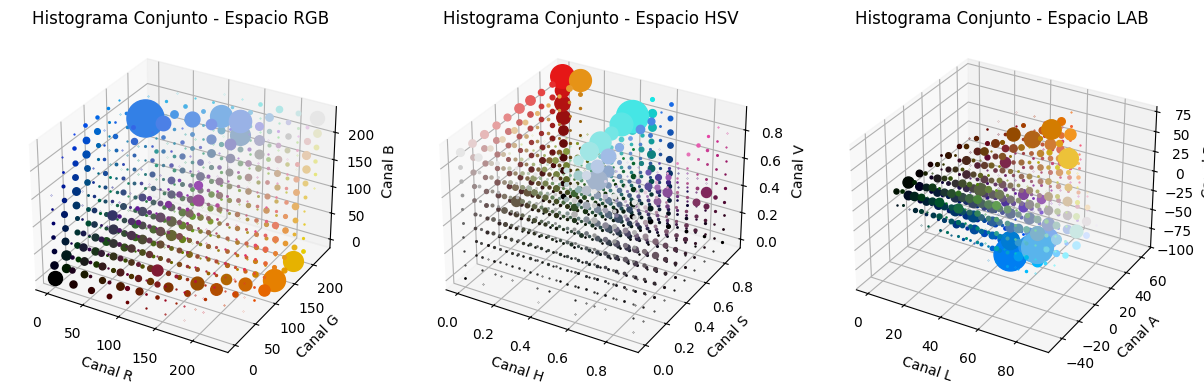

In [16]:
# ESTA CELDA PUEDE DEMORAR EN EJECUTARSE

bins_per_channel = 10
titles = ["RGB", "HSV", "LAB"]

# Se obtienen los histogramas conjuntos y la interseccion de rangos asociada a sus bins
rgb_joint_hist, rgb_bins = joint_histogram(rgb_image, bins_per_channel, color_space_transform = None)
hsv_joint_hist, hsv_bins = joint_histogram(rgb_image, bins_per_channel, color_space_transform = rgb2hsv)
lab_joint_hist, lab_bins = joint_histogram(rgb_image, bins_per_channel, color_space_transform = rgb2lab)

# Visualización
fig = plt.figure(figsize=(15,8))

ax1 = fig.add_subplot(1, 3, 1, projection='3d')
ax1.set_title("Histograma Conjunto - Espacio RGB")
ax1.set_xlabel("Canal R")
ax1.set_ylabel("Canal G")
ax1.set_zlabel("Canal B")

ax2 = fig.add_subplot(1, 3, 2, projection='3d')
ax2.set_title("Histograma Conjunto - Espacio HSV")
ax2.set_xlabel("Canal H")
ax2.set_ylabel("Canal S")
ax2.set_zlabel("Canal V")

ax3 = fig.add_subplot(1, 3, 3, projection='3d')
ax3.set_title("Histograma Conjunto - Espacio LAB")
ax3.set_xlabel("Canal L")
ax3.set_ylabel("Canal A")
ax3.set_zlabel("Canal B")

# Se crean gradillas asociadas a las posibles combinaciones entre los rangos de los bins con el fin de
# poder graficar en 3D

x_rgb, y_rgb, z_rgb = np.meshgrid(rgb_bins[0], rgb_bins[1], rgb_bins[2], indexing="ij")
x_hsv, y_hsv, z_hsv = np.meshgrid(hsv_bins[0], hsv_bins[1], hsv_bins[2], indexing="ij")
x_lab, y_lab, z_lab = np.meshgrid(lab_bins[0], lab_bins[1], lab_bins[2], indexing="ij")

# Se crea un arreglo que define un color en rgb incluido en cada bin, con el propósito de mostrar este color en
# la representación 3D del histograma conjunto
color_dist_rgb = np.stack([x_rgb[:-1, :-1, :-1], y_rgb[:-1, :-1, :-1], z_rgb[:-1, :-1, :-1]], axis=3) / 255
color_dist_hsv = hsv2rgb(np.stack([x_hsv[:-1, :-1, :-1], y_hsv[:-1, :-1, :-1], z_hsv[:-1, :-1, :-1]], axis=3)) 
color_dist_lab = lab2rgb(np.stack([x_lab[:-1, :-1, :-1], y_lab[:-1, :-1, :-1], z_lab[:-1, :-1, :-1]], axis=3))

# Se grafica una burbuja asociada a la frecuencia de cada bin en el espacio de 3 dimensiones. El radio de la burbuja
# es proporcional a cada frecuencia. El color de la burbuja coincide con el color representado por dicho bin

for i in range(x_rgb.shape[0] - 1):
    for j in range(x_rgb.shape[1] - 1):
        for k in range(x_rgb.shape[2] - 1):
            ax1.scatter3D(x_rgb[i, j, k], y_rgb[i, j, k], z_rgb[i, j, k], s=rgb_joint_hist[i, j, k] * 0.01,
                          c=rgb2hex(color_dist_rgb[i, j, k, :]))
            ax2.scatter3D(x_hsv[i, j, k], y_hsv[i, j, k], z_hsv[i, j, k], s=hsv_joint_hist[i, j, k] * 0.01,
                          c=rgb2hex(color_dist_hsv[i, j, k, :]))
            ax3.scatter3D(x_lab[i, j, k], y_lab[i, j, k], z_lab[i, j, k], s=lab_joint_hist[i, j, k] * 0.01,
                          c=rgb2hex(color_dist_lab[i, j, k, :]))



## Espacios de Color

Centrandonos ahora mas en los espacios de color HSV y Lab, el siguiente codigo muestra la representacion visual de cada canal dentro de estos espacios para observar que informacion de la imagen se resaltan en cada uno:

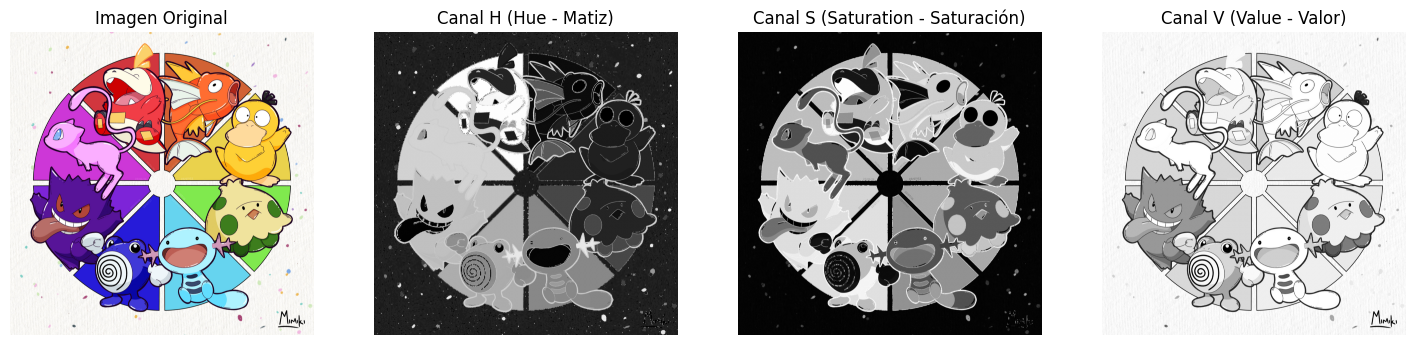

In [17]:
img = imread('rueda.jpg')
hsv_img = rgb2hsv(img)

plt.figure(figsize=(18,8))
plt.subplot(1, 4, 1)
plt.imshow(img)
plt.title("Imagen Original")
plt.axis('Off')
plt.subplot(1, 4, 2)
plt.imshow(hsv_img[:, :, 0], cmap='gray')
plt.title("Canal H (Hue - Matiz)")
plt.axis('Off')
plt.subplot(1, 4, 3)
plt.imshow(hsv_img[:, :, 1], cmap='gray')
plt.title("Canal S (Saturation - Saturación)")
plt.axis('Off')
plt.subplot(1, 4, 4)
plt.imshow(hsv_img[:, :, 2], cmap='gray')
plt.title("Canal V (Value - Valor)")
plt.axis('Off')
plt.show()


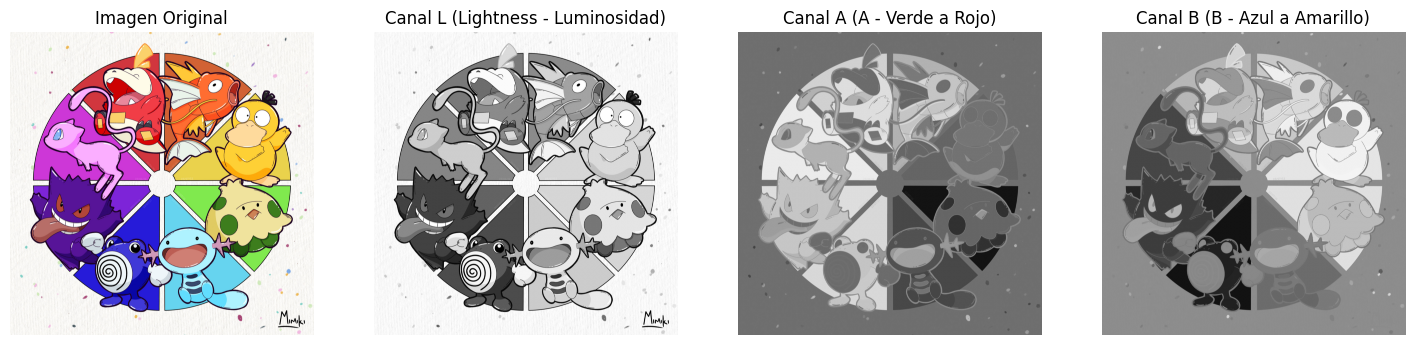

In [18]:
lab_img = rgb2lab(img)

plt.figure(figsize=(18,8))
plt.subplot(1, 4, 1)
plt.imshow(img)
plt.title("Imagen Original")
plt.axis('Off')
plt.subplot(1, 4, 2)
plt.imshow(lab_img[:, :, 0], cmap='gray')
plt.title("Canal L (Lightness - Luminosidad)")
plt.axis('Off')
plt.subplot(1, 4, 3)
plt.imshow(lab_img[:, :, 1], cmap='gray')
plt.title("Canal A (A - Verde a Rojo)")
plt.axis('Off')
plt.subplot(1, 4, 4)
plt.imshow(lab_img[:, :, 2], cmap='gray')
plt.title("Canal B (B - Azul a Amarillo)")
plt.axis('Off')
plt.show()

## Créditos ##
Danniel Moreno - Felipe Escallón Páez - Jose Miguel Abril Nova - Javier Santiago Vera Rincon